# Work in progress.

In [1]:
import numpy as np
import pandas as pd

from bokeh.layouts import layout
from bokeh.embed import file_html

from bokeh.io import show
from bokeh.io import output_notebook

from bokeh.models import Text
from bokeh.models import Plot
from bokeh.models import Slider
from bokeh.models import Circle
from bokeh.models import Range1d
from bokeh.models import CustomJS
from bokeh.models import HoverTool
from bokeh.models import LinearAxis
from bokeh.models import ColumnDataSource
from bokeh.models import SingleIntervalTicker

from bokeh.palettes import Spectral6
pd.set_option('display.max_columns',99)
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
output_notebook()

df = pd.read_csv("../data/dataset_minimal_features_for_modeling.csv")
# We are using the reduced feature dataset, but we stored it post one-hotting and 
# need the school type as a single feature to do the viz we want to do.
df_full = pd.read_csv("../data/dataset_from_ingestion.csv")


def process_data():
    # school_type 
    school_type = df_full.School_Type
    # grad_rate
    grad_rate = df.Grad_Rate
    # Turn enrollment * teacher_ratio2 into bubble sizes. Use min_size and factor to tweak.
    scale_factor = 1 
    min_size = 3
    # enrollment_cohort_ratio = df.Enrollment / df.All_Cohort
    
    sizing_data = np.sqrt(
       df['Enrollment Teacher_Ratio2'] / np.pi) / scale_factor
    # @Note: feature spans 0.08 to 27000
    sizing_data = sizing_data.where(
    sizing_data >= min_size).fillna(min_size)

    # Rla_Pct_Part
    rla_bins = np.percentile(df['Rla_Pct_Part'], np.linspace(0, 100, num=6))
    rla_binned = np.digitize(df.Rla_Pct_Part, bins=rla_bins)

    # Reduced Price Lunch / Cohort size
    reduced_lunch_cohort_ratio = df['Reduced_Price_Lunch Teacher_Ratio2'] 
    rlcr_bins = np.percentile(
        reduced_lunch_cohort_ratio, np.linspace(0, 100, num=3))
    rlcr_binned = np.digitize(reduced_lunch_cohort_ratio, bins=rlcr_bins)
   
    rla_colors = [Spectral6[i] for i in range(1, 5)]

    return school_type, grad_rate, sizing_data, pd.Series(rla_binned),  pd.Series(rlcr_binned), pd.Series(rla_colors), pd.Series(rla_bins), pd.Series(rlcr_bins)



Loading BokehJS ...

In [3]:
school_type, grad_rate, sizing_data, rla_binned,  rlcr_binned, rla_colors, rla_bins, rlcr_bins = process_data()

vars_tup = school_type, grad_rate, sizing_data, rla_binned,  rlcr_binned, rla_colors, rla_bins, rlcr_bins 

print(list(map(len,vars_tup)))
del vars_tup

[83658, 83658, 83658, 83658, 83658, 4, 6, 3]


In [4]:
rlcr_color = pd.Series([Spectral6[bin] for bin in rlcr_binned])

In [5]:
rlcr_binned.value_counts()

1    41829
2    41828
3        1
dtype: int64

In [6]:
sources = {}
all_bins_data = pd.concat([grad_rate,school_type,rla_binned,rlcr_color,sizing_data],sort=True, axis=1)

<AxesSubplot: >

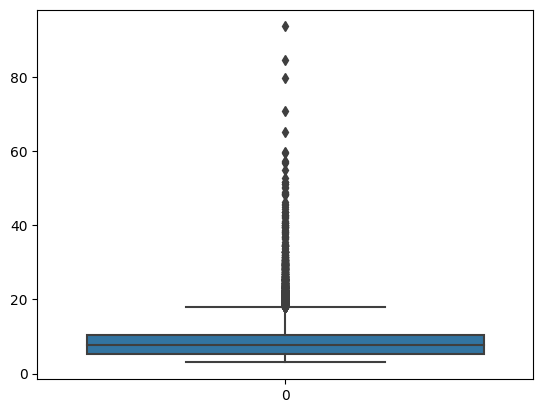

In [7]:
sns.boxplot(sizing_data)

In [8]:
school_groups = all_bins_data.groupby(school_type)

In [9]:
rla_bins = sorted(rla_bins)
print(rla_binned.unique())
rla_binned.value_counts()


[5 2 3 1 6]


5    35371
3    16083
2    11864
1    10885
6     9455
dtype: int64

In [10]:
for school_type_id, g in school_groups:
    g.columns = "Grad_Rate", 'School_Type', 'Rla_Bin', 'Rlcr_Color', 'Sizing_Data'
    print(g.head(),type(g))
    sources['_' + str(school_type_id)] = ColumnDataSource(data=g)

   Grad_Rate  School_Type  Rla_Bin Rlcr_Color  Sizing_Data
0       52.0          1.0        5    #e6f598     8.399189
2       97.5          1.0        5    #e6f598     6.336197
3       90.0          1.0        2    #99d594     3.292948
4       90.0          1.0        3    #99d594     4.741095
5       69.5          1.0        3    #99d594     4.207470 <class 'pandas.core.frame.DataFrame'>
      Grad_Rate  School_Type  Rla_Bin Rlcr_Color  Sizing_Data
322        75.0          2.0        1    #99d594     3.514679
2062       25.0          2.0        1    #99d594     5.129990
2299       67.0          2.0        5    #99d594     4.802001
2396       10.0          2.0        1    #99d594     4.461932
2489       25.0          2.0        1    #99d594     6.682913 <class 'pandas.core.frame.DataFrame'>
     Grad_Rate  School_Type  Rla_Bin Rlcr_Color  Sizing_Data
58        97.5          3.0        5    #99d594     5.683079
70        87.0          3.0        5    #99d594     6.006093
189       34.5 

In [11]:
import pprint
pprint.pprint(sources)

{'_1.0': ColumnDataSource(id='p1002', ...),
 '_2.0': ColumnDataSource(id='p1005', ...),
 '_3.0': ColumnDataSource(id='p1008', ...),
 '_4.0': ColumnDataSource(id='p1011', ...)}


In [12]:
school_types = sorted(school_type.unique())
dictionary_of_sources = dict(zip([x for x in school_types], ['_%s' % x for x in school_types]))
print(dictionary_of_sources)
js_source_array = str(dictionary_of_sources).replace("'", "")

{1.0: '_1.0', 2.0: '_2.0', 3.0: '_3.0', 4.0: '_4.0'}


# Build the plot

In [13]:
# Slider is School Type
# X axis is graduation rate
# Y axis is Rla_Pct_Part


xdr = Range1d(1, 100)
ydr = Range1d(0, 7)
plot = Plot(
    x_range=xdr,
    y_range=ydr,
    outer_width=800,
    outer_height=400,
    outline_line_color=None,
    toolbar_location=None, 
    min_border=20,
)

AXIS_FORMATS = dict(
    major_label_text_font_size="10pt",
    major_label_text_font_style="normal",
    axis_label_text_font_size="10pt",

    axis_line_color='#AAAAAA',
    major_tick_line_color='#AAAAAA',
    major_label_text_color='#666666',

    major_tick_line_cap="round",
    axis_line_cap="round",
    axis_line_width=1,
    major_tick_line_width=1,
)

xaxis = LinearAxis(ticker=SingleIntervalTicker(interval=20), axis_label="Graduation Rate", **AXIS_FORMATS)
yaxis = LinearAxis(ticker=SingleIntervalTicker(interval=1), axis_label="Reading and Language Arts Test Participation", **AXIS_FORMATS)   
plot.add_layout(xaxis, 'below')
plot.add_layout(yaxis, 'left')

school_type_text = ["Regular","Unknown","Vocation", "Alternate"]


In [14]:
# Add stuff for one school type

# Background Text
text_source = ColumnDataSource({'School_Type': [school_type_text[0]]})
text = Text(x=3, y=3.5, text='School_Type', text_font_size='80pt', text_color='#EEEEEE')
plot.add_glyph(text_source, text)

# Add the circle
renderer_source = sources['_%s' % school_types[0]]
circle_glyph = Circle(
    x='Grad_Rate', y='Rla_Bin', size='Sizing_Data',
    fill_color='Rlcr_Color', fill_alpha=0.7, 
    line_color='#7c7e71', line_width=0.5, line_alpha=0.5)

circle_renderer = plot.add_glyph(renderer_source, circle_glyph)

# Add hover
tooltips = "@Rlcr_Bin"
plot.add_tools(HoverTool(tooltips=tooltips, renderers=[circle_renderer]))

In [15]:
show(plot)

In [16]:
text_x = 5 
text_y = 1 
for i, region in enumerate(school_type):
    # plot.add_glyph(Text(x=text_x, y=text_y, text=[region], text_font_size='10pt', text_color='#666666'))
    plot.add_glyph(Circle(x=text_x - 0.1, y=text_y + 2, fill_color=Spectral6[i], size=10, line_color=None, fill_alpha=0.8))
    text_y = text_y - 5

IndexError: tuple index out of range